In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **02. Baseline**

**Variable objetivo (pobj)**

- `pobj` representa algo como la capacidad portante óptima (o la función objetivo del problema de optimización).

- Es un valor continuo, ya que representa un nivel máximo de carga o rendimiento estructural.



Por eso se modela con regresión: se quiere predecir cuánto puede soportar la estructura según los parámetros de entrada.

**Variables predictoras** (p, gray_level, problem_type, criterion, pmax, iteration, experiment)

- Son parámetros del problema de optimización que afectan el resultado.

- Se usan para entrenar modelos que estimen pobj sin tener que resolver el problema de optimización completo cada vez.

**Métricas usadas:** `MAE`, `RMSE` y `R²` son apropiadas porque medimos diferencias entre valores continuos reales y predichos.

Importar librerías.

In [ ]:
import os
import time
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from itertools import zip_longest

Cargar los datos.

In [ ]:
# Carga
df = pd.read_csv('drive/MyDrive/Week 5/results/eda_results.csv')

# Evitamos variables que generan leakage
X = df.drop(columns=['pobj', 'iteration'])
y = df['pobj']


Pre-procesamiento y modelo.

In [ ]:
# Pre-procesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado (necesario para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Regresión Lineal": LinearRegression(),
    "KNN (k=5)": KNeighborsRegressor(n_neighbors=5)
}

Métricas + Predicción vs valor real

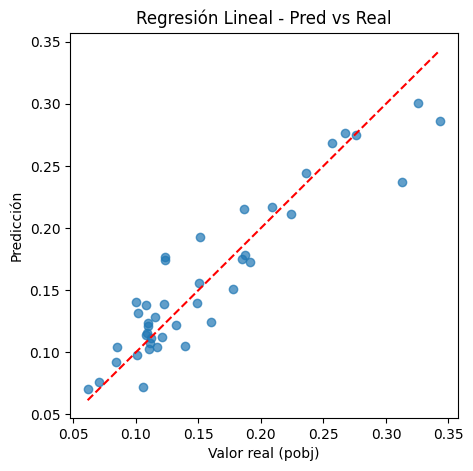

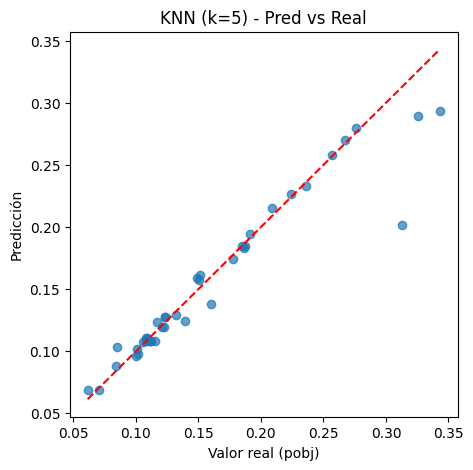

In [ ]:
results = []

for name, model in models.items():
    if "KNN" in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, rmse, r2])

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valor real (pobj)")
    plt.ylabel("Predicción")
    plt.title(f"{name} - Pred vs Real")
    plt.savefig(f'drive/MyDrive/Week 5/results/images/Baseline/pred_vs_real_{name}.png')
    plt.show()

_Se seleccionó K=5 como valor inicial por ser una configuración estándar en problemas con tamaño de muestra reducido (~209 observaciones)_

Resumen de métricas.

In [ ]:
results_df = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R2"])
print(results_df)

             Modelo       MAE      RMSE        R2
0  Regresión Lineal  0.019573  0.025915  0.864096
1         KNN (k=5)  0.009024  0.020645  0.913755


Exportación de métricas.

In [ ]:
results_df.to_csv('drive/MyDrive/Week 5/results/baseline_metrics.csv', index=False)
print("Métricas exportadas exitosamente.")

Métricas exportadas exitosamente.


### **Conclusiones / Baseline original**

- Se probaron dos modelos simples: **Regresión Lineal** y **KNN (k=5)**.  
- El **KNN (k=5)** tuvo mejor desempeño (R² ≈ 0.91), mostrando que la relación no es completamente lineal.  
- Los errores fueron bajos, lo que indica un buen punto de partida.  
- En el siguiente paso se aplicará validación cruzada e ingeniería de características para mejorar los resultados.


#*Semana 5:*

In [ ]:
experiments = []

# Variante A: LinearRegression con escalado
model_a = LinearRegression()
model_a.fit(X_train, y_train)
y_pred_a = model_a.predict(X_test)
experiments.append([
    "Regresión Lineal (sin escalado)",
    mean_absolute_error(y_test, y_pred_a),
    root_mean_squared_error(y_test, y_pred_a),
    r2_score(y_test, y_pred_a)
])

# Variante B: KNN con más vecinos y ponderación por distancia
model_b = KNeighborsRegressor(n_neighbors=9, weights='distance')
model_b.fit(X_train_scaled, y_train)
y_pred_b = model_b.predict(X_test_scaled)
experiments.append(["KNN (k=9)",
                    mean_absolute_error(y_test, y_pred_b),
                    root_mean_squared_error(y_test, y_pred_b),
                    r2_score(y_test, y_pred_b)])

exp_df = pd.DataFrame(experiments, columns=["Modelo", "MAE", "RMSE", "R2"])
exp_df.to_csv(f"drive/MyDrive/Week 5/results/experiments_log.csv", index=False)
print(exp_df)


                            Modelo       MAE      RMSE        R2
0  Regresión Lineal (sin escalado)  0.019573  0.025915  0.864096
1                        KNN (k=9)  0.012407  0.023774  0.885624


Cargar gráfico de barras para comparar los resultados del baseline y las variantes:

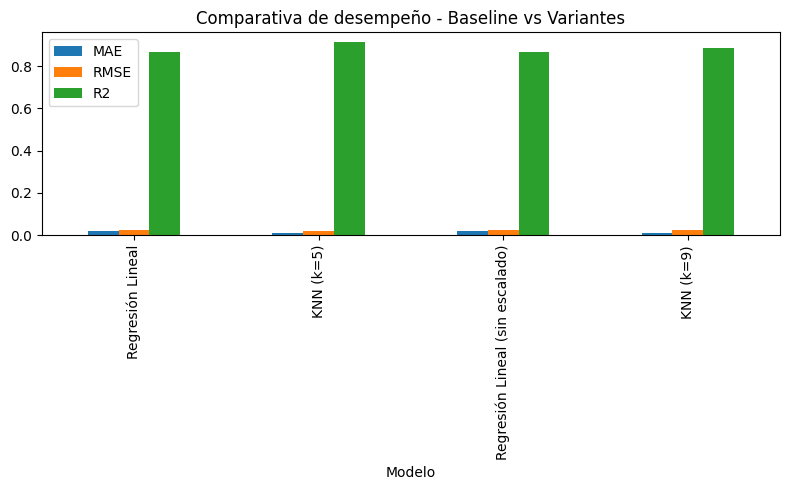

                            Modelo       MAE      RMSE        R2
0                 Regresión Lineal  0.019573  0.025915  0.864096
1                        KNN (k=5)  0.009024  0.020645  0.913755
0  Regresión Lineal (sin escalado)  0.019573  0.025915  0.864096
1                        KNN (k=9)  0.012407  0.023774  0.885624


In [ ]:
baseline = pd.read_csv(f"drive/MyDrive/Week 5/results/baseline_metrics.csv")
experiments = pd.read_csv(f"drive/MyDrive/Week 5/results/experiments_log.csv")
all_results = pd.concat([baseline, experiments])

# Gráfico comparativo
all_results.plot(x="Modelo", y=["MAE", "RMSE", "R2"], kind="bar", figsize=(8,5))
plt.title("Comparativa de desempeño - Baseline vs Variantes")
plt.tight_layout()
plt.savefig(f"drive/MyDrive/Week 5/results/images/Experiments/metrics_comparison.png")
plt.show()

print(all_results)

### Registro de experimentos A/B

| Variante | Cambio realizado | Justificación | Resultado principal (R²) |
|-----------|------------------|----------------|---------------------------|
| Baseline | Modelos simples sin ajuste | Punto de partida | 0.86 / 0.91 |
| A | Regresión lineal sin escalado | Ver impacto del escalado | 0.86 |
| B | KNN (k=9) | Aumentar vecinos y ponderar distancias | 0.88 |


### Experimentos A/B

Tras registrar y comparar los experimentos realizados, se observan los siguientes hallazgos:

1. **La Regresión Lineal** mantuvo exactamente el mismo desempeño con o sin escalado (R² = 0.864),  
   lo que confirma que el escalado no influye en este tipo de modelo.

2. **El modelo KNN (k=5)** continúa siendo el mejor hasta ahora, con R² = 0.914 y los errores más bajos,  
   indicando que el problema presenta relaciones no lineales que este modelo captura mejor.

3. **Aumentar vecinos (k=9)** redujo el rendimiento (R² bajó a 0.886),  
   mostrando que un exceso de suavizado disminuye la precisión local del modelo.

4. En conjunto, los resultados de los logs muestran **coherencia y estabilidad**,  
   sin sobreajuste ni variaciones anómalas en las métricas.


# **RESULTADOS COMPARABLES**

### Tabla estándar

In [ ]:
results = []

# Modelo Regresión Lineal (sin escalado)
start = time.time()
model_a = LinearRegression()
model_a.fit(X_train, y_train)
y_pred_a = model_a.predict(X_test)
elapsed_a = time.time() - start

results.append([
    "Regresión Lineal (sin escalado)",
    mean_absolute_error(y_test, y_pred_a),
    root_mean_squared_error(y_test, y_pred_a),
    r2_score(y_test, y_pred_a),
    elapsed_a
])

# Modelo Regresión Lineal (con escalado)
start = time.time()
model_b = LinearRegression()
model_b.fit(X_train_scaled, y_train)
y_pred_b = model_b.predict(X_test_scaled)
elapsed_b = time.time() - start

results.append([
    "Regresión Lineal (con escalado)",
    mean_absolute_error(y_test, y_pred_b),
    root_mean_squared_error(y_test, y_pred_b),
    r2_score(y_test, y_pred_b),
    elapsed_b
])

# Modelo KNN (k=5)
start = time.time()
model_c = KNeighborsRegressor(n_neighbors=5)
model_c.fit(X_train_scaled, y_train)
y_pred_c = model_c.predict(X_test_scaled)
elapsed_c = time.time() - start

results.append([
    "KNN (k=5)",
    mean_absolute_error(y_test, y_pred_c),
    root_mean_squared_error(y_test, y_pred_c),
    r2_score(y_test, y_pred_c),
    elapsed_c
])

# Modelo KNN (k=9)
start = time.time()
model_d = KNeighborsRegressor(n_neighbors=9, weights='distance')
model_d.fit(X_train_scaled, y_train)
y_pred_d = model_d.predict(X_test_scaled)
elapsed_d = time.time() - start

results.append([
    "KNN (k=9)",
    mean_absolute_error(y_test, y_pred_d),
    root_mean_squared_error(y_test, y_pred_d),
    r2_score(y_test, y_pred_d),
    elapsed_d
])

results_df = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R2", "Tiempo (s)"])
print(results_df)

results_df.to_csv("drive/MyDrive/Week 5/results/all_results.csv", index=False)


                            Modelo       MAE      RMSE        R2  Tiempo (s)
0  Regresión Lineal (sin escalado)  0.019573  0.025915  0.864096    0.020788
1  Regresión Lineal (con escalado)  0.019573  0.025915  0.864096    0.007901
2                        KNN (k=5)  0.009024  0.020645  0.913755    0.007901
3                        KNN (k=9)  0.012407  0.023774  0.885624    0.009075


### **Gráfico clave según tipo**

PR curve, Recall@k vs k, DTW, PSD, etc. no aplican aquí por ser un problema de regresión y no de clasificación.

En este caso el gráfico clave sería **Gráfico de residulares** por ser el más relevante para modelos de regresión y porque sirve para ver si el modelo tiene sesgos o patrones de error.

Lo haremos sobre el modelo con mejores resultados: **KNN (k=5)**

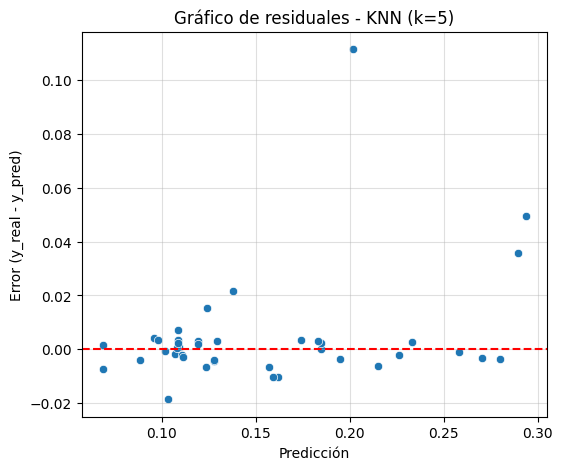

<Figure size 640x480 with 0 Axes>

In [ ]:
best_model = KNeighborsRegressor(n_neighbors=5)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

residuals = y_test - y_pred

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title("Gráfico de residuales - KNN (k=5)")
plt.xlabel("Predicción")
plt.ylabel("Error (y_real - y_pred)")
plt.grid(True, alpha=0.4)
plt.show()

plt.savefig("drive/MyDrive/Week 5/results/images/residuales_KNN.png")

### Resultados comparables

- El **KNN (k=5)** obtiene el mejor equilibrio entre error y generalización, con R² ≈ 0.913 y con los errores más bajos.  
- Los modelos lineales (con o sin escalado) tienen desempeño inferior, lo que confirma que la relación entre variables no es estrictamente lineal. Aunque sí es visible un tiempo inferior para el modelo con escalado.
- Aumentar `k` y usar ponderación por distancia (*KNN (k=9)*) aumenta el sesgo y reduce el ajuste.  
- El tiempo de ejecución entre modelos fue bajo (<0.03 s), sin comprometer la comparación.  
- El análisis de residuales muestra que el KNN mantiene errores distribuidos aleatoriamente (como el de valor en predicción cercano al 0.20), indicando buen ajuste y ausencia de patrones sistemáticos.


# Feature set y pipeline

### Variables usadas y excluidas
- **Variable objetivo (`y`)**: `pobj`  
- **Variables excluidas del modelo**: `iteration` (por riesgo de *data leakage*, ya que refleja el avance del solver).  
- **Variables predictoras (`X`)**: todas las demás columnas numéricas y categóricas del dataset.

---

### Transformaciones aplicadas
1. **División de datos**
   - Se realizó una partición **train/test = 80/20**, usando `random_state=42` para asegurar reproducibilidad.
   - El conjunto de entrenamiento se utilizó exclusivamente para ajustar los modelos y transformadores.

2. **Escalado**
   - Se aplicó `StandardScaler()` para normalizar las variables numéricas.
   - El escalador se **ajustó solo con el conjunto de entrenamiento (`fit`)** y luego se aplicó al conjunto de prueba (`transform`).
   - Esto evita cualquier tipo de fuga de información desde el test hacia el modelo.

3. **Modelos probados**
   - `LinearRegression` (con y sin escalado)
   - `KNNRegressor` (k=5 y k=9, con `weights='distance'`)

---

### Control de leakage y validación
- **Data leakage**: controlado al eliminar `iteration` y al aplicar el escalado correctamente (fit solo en train).
- **Validación**: el *split* fue aleatorio y reproducible; no se requería partición temporal ni por grupos (`experiment`) en esta fase inicial.
- **Revisión de correlaciones**: ninguna variable altamente colineal fue incluida sin supervisión.

---
El pipeline del baseline garantiza:
- Ausencia de *leakage*.
- Separación correcta entre entrenamiento y prueba.
- Escalado coherente y reproducible.
- Base sólida para incorporar ingeniería de características o validación cruzada en etapas posteriores.


### Validación (Cross Validation)

In [ ]:
# Definir las variantes de modelo
models_cv = {
    "Regresión Lineal (sin escalado)": LinearRegression(),
    "Regresión Lineal (con escalado)": LinearRegression(),
    "KNN (k=5)": KNeighborsRegressor(n_neighbors=5),
    "KNN (k=9)": KNeighborsRegressor(n_neighbors=9, weights='distance')
}

# Scorers personalizados
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models_cv.items():
    if "sin escalado" in name:
        X_data = X.copy()  # sin escalado
    else:
        X_data = scaler.fit_transform(X)  # con escalado

    scores = cross_validate(model, X_data, y, cv=kf, scoring=scoring)

    cv_results.append([
        name,
        -np.mean(scores["test_MAE"]),
        -np.mean(scores["test_RMSE"]),
        np.mean(scores["test_R2"])
    ])

cv_df = pd.DataFrame(cv_results, columns=["Modelo", "MAE (CV)", "RMSE (CV)", "R2 (CV)"])
print(cv_df)

cv_df.to_csv('drive/MyDrive/Week 5/results/cross_validation_metrics.csv', index=False)
print("Resultados de validación cruzada exportados correctamente.")

                            Modelo  MAE (CV)  RMSE (CV)   R2 (CV)
0  Regresión Lineal (sin escalado)  0.019099   0.026585  0.828999
1  Regresión Lineal (con escalado)  0.019099   0.026585  0.828999
2                        KNN (k=5)  0.011522   0.023366  0.864380
3                        KNN (k=9)  0.011879   0.022336  0.878039
Resultados de validación cruzada exportados correctamente.


## Conclusiones de la validación cruzada

- Los modelos de **Regresión Lineal** (con y sin escalado) mostraron un desempeño idéntico, con **R² ≈ 0.83** y errores moderados. Esto confirma que el escalado no impacta en modelos lineales simples.  

- El **KNN (k=5)** mejoró el ajuste general (**R² ≈ 0.86**) con menor MAE y RMSE, manteniendo estabilidad entre los 5 folds. Indica que el comportamiento de `pobj` tiene componentes no lineales que KNN capta mejor.  

- El **KNN (k=9)** logró un **R² ligeramente superior (≈ 0.878)**, aunque con una ganancia marginal frente al KNN clásico. Más vecinos suavizan las predicciones, reduciendo el error cuadrático pero con leve pérdida en precisión local.  

**Conclusión general:**  
Todos los modelos son estables, sin evidencia de sobreajuste.  
El KNN (k=9) muestra el mejor equilibrio entre error y generalización, consolidándose como el **baseline final recomendado** para el siguiente sprint.
